We now need to create the final white light curve, taking into account the wavelength ranges we considered in #5, the resampling and the wavelength solution. We also need to standardize the ancillary data.

In [2]:
%matplotlib nbagg

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import reduction_utils.wavelength_calibration as wc

Define the contact points and wavelength range as used in notebook 5:

In [5]:
contact1 = 0
contact4 = 29

min_wvl = 3500
max_wvl = 7300

Load in the data:

In [7]:
parent_direc = '/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/reduction_5_other_trace/'

star1_flux = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_flux_resampled.pickle','rb'))
star2_flux = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_flux_resampled.pickle','rb'))

error1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_error_resampled.pickle','rb'))
error2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_error_resampled.pickle','rb'))

wvl_solution_1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/wavelength_solution.pickle','rb'))

mjd = pickle.load(open(parent_direc+'pickled_objects/mjd_time.pickle','rb'))
bad_frames = []  
good_frames = np.setdiff1d(np.arange(mjd.shape[0]), bad_frames)
mjd = mjd[good_frames]

am = pickle.load(open(parent_direc+'pickled_objects/airmass.pickle','rb'))
am = am[good_frames]

exp_times = pickle.load(open(parent_direc+'pickled_objects/exposure_times.pickle','rb'))
exp_times = exp_times[good_frames]

xpos1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos1_resampled.pickle','rb'))
sky1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky1_resampled.pickle','rb'))
fwhm1 = pickle.load(open(parent_direc+'pickled_objects/fwhm_1.pickle','rb'))
fwhm1 = fwhm1[good_frames]

xpos2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos2_resampled.pickle','rb'))
sky2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky2_resampled.pickle','rb'))
fwhm2 = pickle.load(open(parent_direc+'pickled_objects/fwhm_2.pickle','rb'))
fwhm2 = fwhm2[good_frames]

print(len(sky1))
print(len(fwhm1))
print(len(mjd))
print(np.size(sky1))
print(sky1.shape)

53
53
53
50933
(53, 961)


Load in y shifts, as calculated from 3_spectra_resampling.ipynb

In [8]:
ypos1 = pickle.load(open(parent_direc+'pickled_objects/ypos1.pickle','rb'))
ypos1_smooth = pickle.load(open(parent_direc+'pickled_objects/ypos1_smooth.pickle','rb'))

ypos2 = pickle.load(open(parent_direc+'pickled_objects/ypos2.pickle','rb'))
ypos2_smooth = pickle.load(open(parent_direc+'pickled_objects/ypos2_smooth.pickle','rb'))


Define time as fractional days:

In [9]:
time = mjd - int(mjd[0])

Rescale sky for differing exposure times:

In [10]:
sky1 = np.array([i/j for i,j in zip(sky1,exp_times)])
sky2 = np.array([i/j for i,j in zip(sky2,exp_times)])

As before, remove frame 5 and cut at frame 84

In [11]:
start_idx = 0
end_idx = -1

if end_idx == -1:
    end_idx = None

star1_flux = np.vstack((star1_flux[start_idx:end_idx]))
star2_flux = np.vstack((star2_flux[start_idx:end_idx]))

error1 = np.vstack((error1[start_idx:end_idx]))
error2 = np.vstack((error2[start_idx:end_idx]))

mjd = np.hstack((mjd[start_idx:end_idx]))

time = np.hstack((time[start_idx:end_idx]))

exp_times = np.hstack((exp_times[start_idx:end_idx]))

sky1 = np.vstack((sky1[start_idx:end_idx]))
sky2 = np.vstack((sky2[start_idx:end_idx]))

xpos1 = np.vstack((xpos1[start_idx:end_idx]))
xpos2 = np.vstack((xpos2[start_idx:end_idx]))

fwhm1 = np.hstack((fwhm1[start_idx:end_idx]))
fwhm2 = np.hstack((fwhm2[start_idx:end_idx]))

ypos1 = np.hstack((ypos1[start_idx:end_idx]))
ypos2 = np.hstack((ypos2[start_idx:end_idx]))

ypos1_smooth = np.hstack((ypos1_smooth[start_idx:end_idx]))
ypos2_smooth = np.hstack((ypos2_smooth[start_idx:end_idx]))

am = np.hstack((am[start_idx:end_idx]))

nframes = len(star1_flux)

print('star1_flux:',np.shape(star1_flux),'error1: ',np.shape(error1),'mjd: ',np.shape(mjd),'time: ',np.shape(time),'exp_times: ',np.shape(exp_times),'sky1: ',np.shape(sky1),'xpos1: ',np.shape(xpos1),'fwhm1: ',np.shape(fwhm1),'ypos1: ',np.shape(ypos1),'am: ',np.shape(am))

star1_flux: (53, 961) error1:  (53, 961) mjd:  (53,) time:  (53,) exp_times:  (53,) sky1:  (53, 961) xpos1:  (53, 961) fwhm1:  (53,) ypos1:  (53,) am:  (53,)


Now cut only consider the wavelength range used for the spectroscopic light curves:

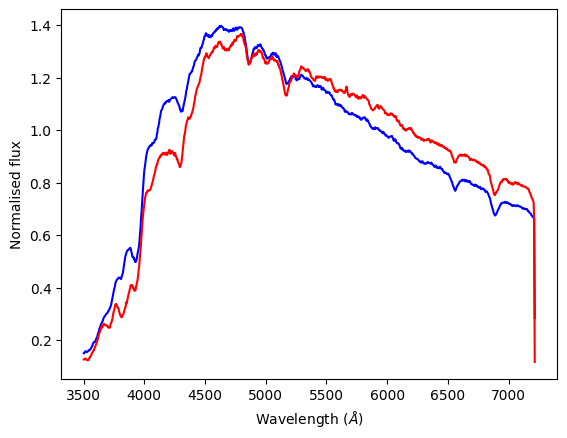

In [12]:
blue_mask = wvl_solution_1 < min_wvl
red_mask = wvl_solution_1 > max_wvl
combined_mask = blue_mask + red_mask

# Invert the mask
combined_mask = ~combined_mask


plt.figure()
plt.plot(wvl_solution_1[combined_mask],wc.normalise(star1_flux[nframes//2][combined_mask]),'b')
plt.plot(wvl_solution_1[combined_mask],wc.normalise(star2_flux[nframes//2][combined_mask]),'r')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised flux')
plt.show()

And perform the cut:

In [13]:
s1 = star1_flux[:,combined_mask]
s2 = star2_flux[:,combined_mask]

e1 = error1[:,combined_mask]
e2 = error2[:,combined_mask]

sky1 = sky1[:,combined_mask]
xpos1 = xpos1[:,combined_mask]

sky2 = sky2[:,combined_mask]
xpos2 = xpos2[:,combined_mask]

wvl = wvl_solution_1[combined_mask]

Now create the white light curve, normalise to the out of transit data and plot:

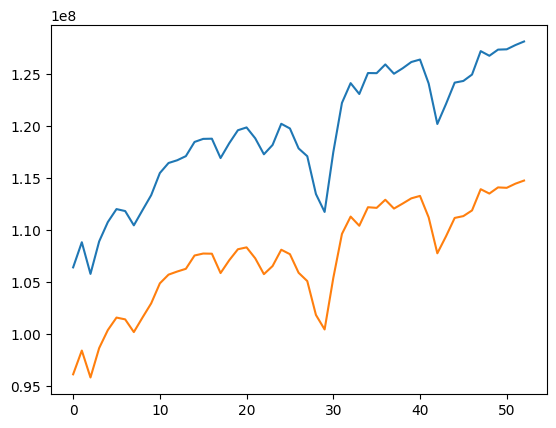

In [14]:
plt.plot(np.sum(s1,axis=1))
plt.plot(np.sum(s2,axis=1))

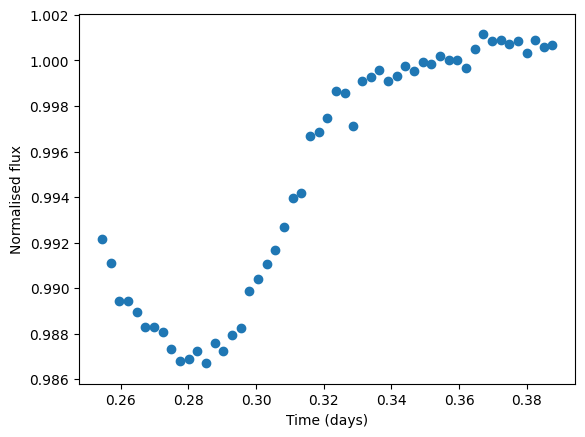

In [15]:
ratio = np.sum(s1,axis=1)/np.sum(s2,axis=1)
err_ratio = np.sqrt((np.sqrt(np.sum(e1**2,axis=1))/np.sum(s1,axis=1))**2 \
                    + (np.sqrt(np.sum(e2**2,axis=1))/np.sum(s2,axis=1))**2)*ratio


flux = ratio/np.median(ratio[:contact1].tolist()+ratio[contact4:].tolist())
error = (err_ratio/ratio) * flux

plt.figure()
plt.errorbar(time,flux,yerr=error,fmt='o',ecolor='k',capsize=0)
plt.ylabel('Normalised flux')
plt.xlabel('Time (days)')
plt.show()

And save the output:

In [17]:
pickle.dump(flux,open(parent_direc+'pickled_objects/WL/white_light_flux.pickle','wb'))
pickle.dump(error,open(parent_direc+'pickled_objects/WL/white_light_error.pickle','wb'))

Now combine and standardize the ancillary data for use in the fitting process.  This is done via subtracting the mean and dividing by the standard deviation.

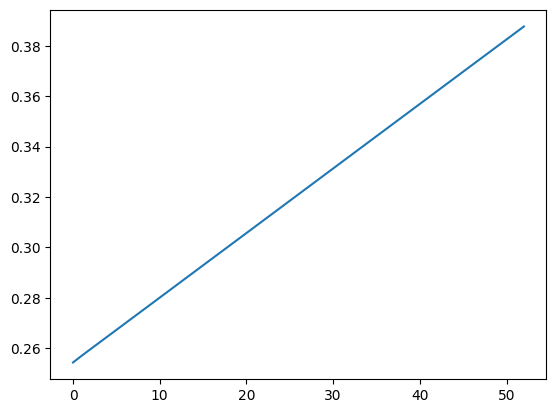

In [18]:
plt.plot(time)

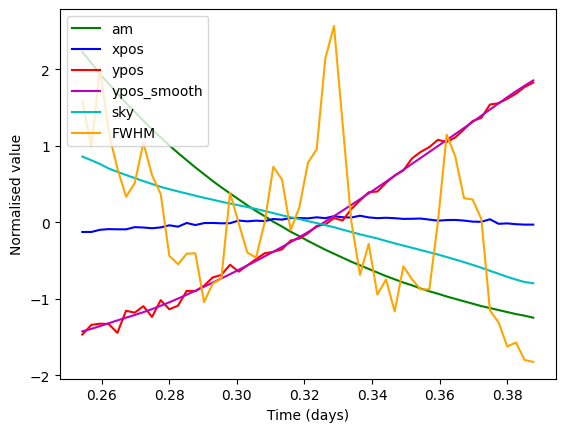

In [19]:

xpos1_norm = (xpos1.mean(axis=1)-xpos1.mean())/xpos1.std()
xpos2_norm = (xpos2.mean(axis=1)-xpos2.mean())/xpos2.std()

xpos = np.mean((xpos1_norm,xpos2_norm),axis=0)

ypos1_norm = (ypos1-ypos1.mean())/ypos1.std()
ypos2_norm = (ypos2-ypos2.mean())/ypos2.std()

# combine ypos into a single array from star 1 and star 2
ypos = np.mean((ypos1_norm,ypos2_norm),axis=0)

ypos1_smooth_norm = (ypos1_smooth-ypos1_smooth.mean())/ypos1_smooth.std()
ypos2_smooth_norm = (ypos2_smooth-ypos2_smooth.mean())/ypos2_smooth.std()

# combine ypos_smooth into a single array from star 1 and star 2
ypos_smooth  = np.mean((ypos1_smooth_norm,ypos2_smooth_norm),axis=0)

sky1_norm = (sky1.mean(axis=1)-sky1.mean())/sky1.std()
sky2_norm = (sky2.mean(axis=1)-sky2.mean())/sky2.std()

sky = np.mean((sky1_norm,sky2_norm),axis=0)

fwhm1_norm = (fwhm1-fwhm1.mean())/fwhm1.std()
fwhm2_norm = (fwhm2-fwhm2.mean())/fwhm2.std()

fwhm = np.mean((fwhm1_norm,fwhm2_norm),axis=0)

am_norm = (am-am.mean())/am.std()

plt.figure()
plt.plot(time,am_norm,'g',label='am')
plt.plot(time,xpos,'b',label='xpos')
plt.plot(time,ypos,'r',label='ypos')
plt.plot(time,ypos_smooth,'m',label='ypos_smooth')
plt.plot(time,sky,'c',label='sky')
plt.plot(time,fwhm,'orange',label='FWHM')
plt.xlabel('Time (days)')
plt.ylabel('Normalised value')
plt.legend(loc='upper left')
plt.show()

#fwhm_norm.pickle,xpos_norm.pickle,ypos_norm.pickle,am_norm.pickle,sky_norm.pickle

And save the output:

In [20]:
am_norm

array([ 2.22555582,  2.07929459,  1.93825698,  1.80766659,  1.68229982,
        1.55693305,  1.44201352,  1.32709398,  1.21217444,  1.10770213,
        1.00322983,  0.90398113,  0.80995606,  0.71593098,  0.62712952,
        0.53832806,  0.45475021,  0.37639598,  0.29804175,  0.21968752,
        0.14655691,  0.07864991,  0.00551929, -0.05716409, -0.12507109,
       -0.18253086, -0.24521425, -0.30267401, -0.36013378, -0.41236994,
       -0.46460609, -0.51684224, -0.56385478, -0.61086732, -0.65787986,
       -0.7048924 , -0.74668132, -0.78847024, -0.82503555, -0.86682447,
       -0.90338978, -0.93473147, -0.97129678, -1.00263847, -1.03398017,
       -1.06532186, -1.09666355, -1.12278163, -1.1488997 , -1.17501778,
       -1.20113586, -1.22203032, -1.24814839])

In [21]:
pickle.dump(am_norm,open(parent_direc+'pickled_objects/WL/am_norm.pickle','wb'))

pickle.dump(fwhm,open(parent_direc+'pickled_objects/WL/fwhm_norm.pickle','wb'))

pickle.dump(sky,open(parent_direc+'pickled_objects/WL/sky_norm.pickle','wb'))

pickle.dump(xpos,open(parent_direc+'pickled_objects/WL/xpos_norm.pickle','wb'))

pickle.dump(ypos,open(parent_direc+'pickled_objects/WL/ypos_norm.pickle','wb'))

pickle.dump(ypos_smooth,open(parent_direc+'pickled_objects/WL/ypos_smooth_norm.pickle','wb'))

pickle.dump(time,open(parent_direc+'pickled_objects/WL/time_norm.pickle','wb'))

We also want to calculate the central wavelength and wavelength range used for the white light curve to calculate the limb darkening coefficients.

In [22]:
wvl_centre = np.array([(max_wvl+min_wvl)//2])
wvl_error = np.array([max_wvl-min_wvl])

print(wvl_centre,wvl_error)


[5400] [3800]


And save:

In [23]:
pickle.dump(wvl_centre,open(parent_direc+'pickled_objects/WL/white_wvl_centre.pickle','wb'))
pickle.dump(wvl_error,open(parent_direc+'pickled_objects/WL/white_wvl_error.pickle','wb'))

Now we have spectroscopic and white light curves, we can fit the data!

In [24]:
pwd

'/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/EFOSC_utils/example_notebooks (WASP168 night 4)'

1.76 1.095 1.095


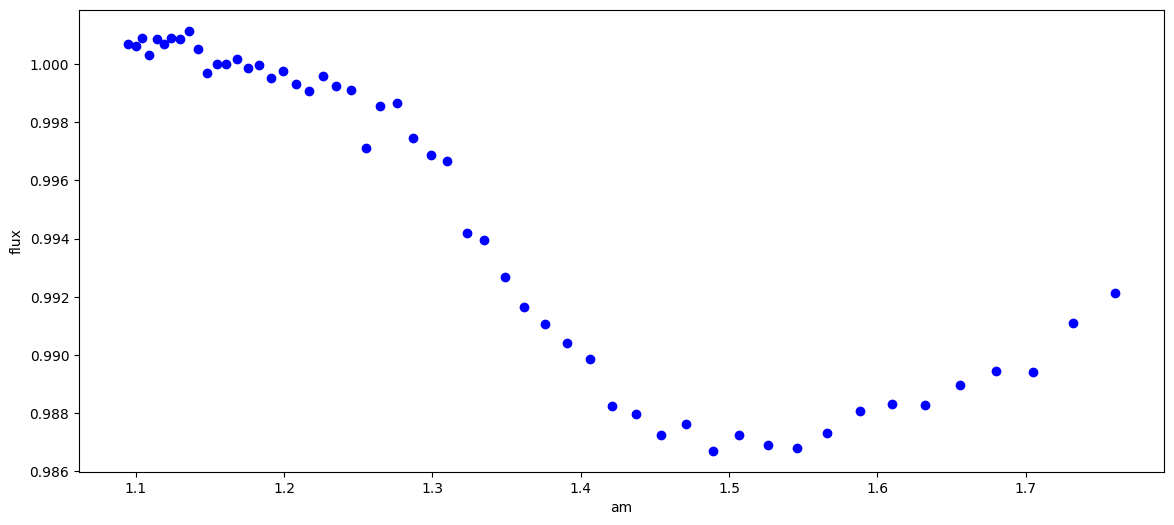

In [25]:
print(am[0],min(am),am[-1])

plt.figure(figsize=(14,6))
plt.plot(am,flux,'bo')
plt.ylabel('flux')
plt.xlabel('am')
plt.show()

0.000998134117666196 -0.004042967279309625 -0.004042967279309625


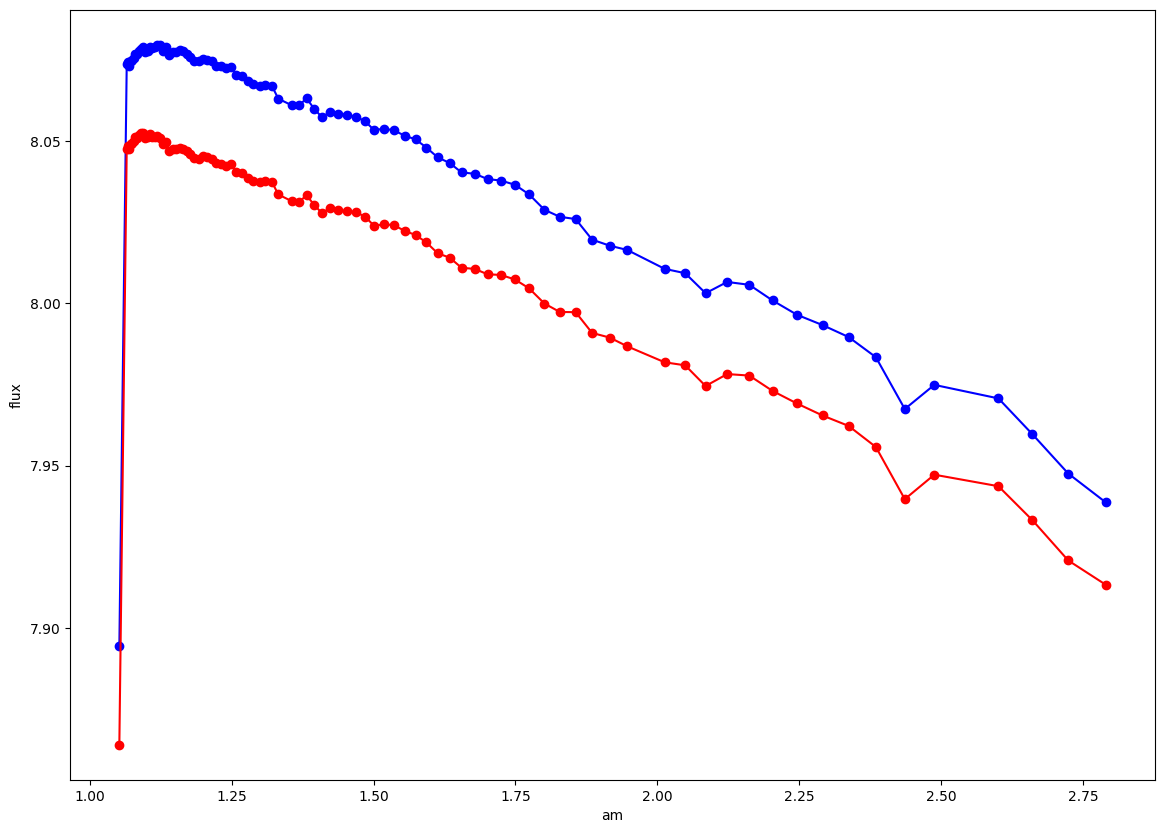

In [31]:
extinction = np.exp(-am)
extinction = np.log10(flux)
print(extinction[0],min(extinction),extinction[-1])

plt.figure(figsize=(14,10))
plt.plot(am,np.log10(np.sum(s1,axis=1)),'b-o')
plt.plot(am,np.log10(np.sum(s2,axis=1)),'r-o')
plt.ylabel('flux')
plt.xlabel('am')
plt.show()


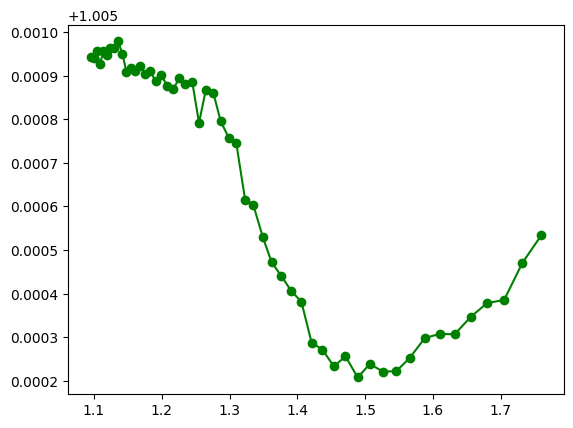

In [26]:
plt.plot(am,np.log10(np.sum(s1,axis=1))/np.log10(np.sum(s2,axis=1)),'g-o')

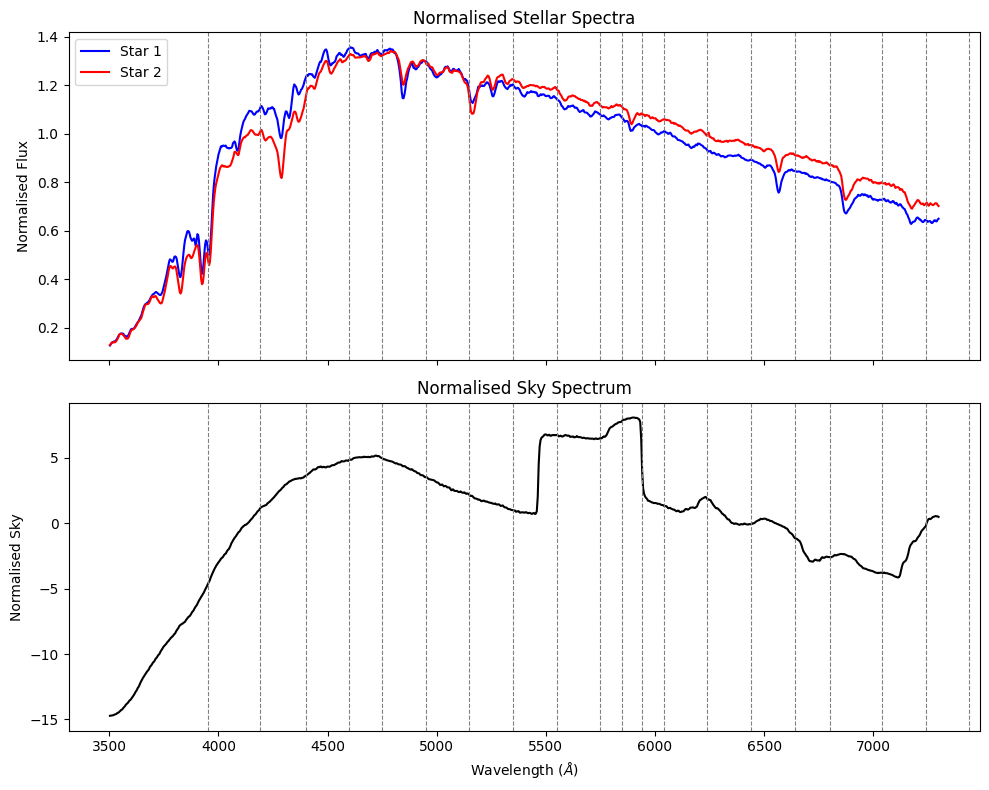

In [33]:
import matplotlib.pyplot as plt

# Prepare sky_other
sky1_norm_other = (sky1.mean(axis=0) - sky1.mean()) / sky1.std()
sky2_norm_other = (sky2.mean(axis=0) - sky2.mean()) / sky2.std()
sky_other = np.mean((sky1_norm_other, sky2_norm_other), axis=0)

# Define bin edges
bin_edges = [3950, 4190, 4400, 4600, 4750, 4950, 5150, 5350, 5550, 5750,
             5850, 5940, 6040, 6240, 6440, 6640, 6800, 7040, 7240, 7440]

# Set up figure with two vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# First subplot: stellar fluxes
axs[0].plot(wvl_solution_1[combined_mask], wc.normalise(star1_flux[nframes//2][combined_mask]), 'b', label='Star 1')
axs[0].plot(wvl_solution_1[combined_mask], wc.normalise(star2_flux[nframes//2][combined_mask]), 'r', label='Star 2')
axs[0].set_ylabel('Normalised Flux')
axs[0].set_title('Normalised Stellar Spectra')
axs[0].legend()

# Second subplot: sky
axs[1].plot(wvl_solution_1[combined_mask], wc.normalise(sky_other), 'k')
axs[1].set_xlabel('Wavelength ($\AA$)')
axs[1].set_ylabel('Normalised Sky')
axs[1].set_title('Normalised Sky Spectrum')

# Add dashed vertical bin edge lines to both subplots
for ax in axs:
    for edge in bin_edges:
        ax.axvline(edge, linestyle='--', color='gray', linewidth=0.8)

plt.tight_layout()
plt.show()

#import reduction_utils.wavelength_binning as wb
#wb.plot_spectra(np.sum(s1,axis=1)[nframes//2],np.sum(s1,axis=1)[nframes//2],wvl_solution_1,\
#                bin_edges=bin_edges,ratio=True,save_fig=False,alkali=True,telluric=True)

In [38]:
np.size(wvl_solution_1[combined_mask])
np.size(sky_other)

932